In [1]:
# ✅ Install dependencies (if not already)
!pip install -q --upgrade scikit-learn==1.1.3 imbalanced-learn==0.10.1

# ✅ Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score, cohen_kappa_score,
                             precision_score, recall_score, f1_score,
                             roc_curve, auc, roc_auc_score, matthews_corrcoef)
from imblearn.metrics import geometric_mean_score, specificity_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 58.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


2025-07-01 03:25:56.010490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751340356.204735      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751340356.262969      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ✅ Pretrained models
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50V2, InceptionV3, InceptionResNetV2,
    DenseNet121, DenseNet169, DenseNet201, Xception, EfficientNetB0,
    MobileNetV3Large
)

In [3]:
# ✅ Dataset paths
violence_folder = '/kaggle/input/hdataset/Hdataset/Fight'
nonviolence_folder = '/kaggle/input/hdataset/Hdataset/Nofight'

In [4]:
# ✅ Load image function
def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        try:
            img = load_img(path, target_size=(224, 224))
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(label)
        except:
            print(f"Error loading {path}")
    return np.array(images), np.array(labels)

In [5]:
# ✅ Build model
def build_transfer_learning_model(base_model_fn, input_shape=(224, 224, 3), lr=0.001):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
# ✅ Load and prepare data
v_images, v_labels = load_images_from_folder(violence_folder, 1)
nv_images, nv_labels = load_images_from_folder(nonviolence_folder, 0)
X = np.concatenate((v_images, nv_images), axis=0)
y = np.concatenate((v_labels, nv_labels), axis=0)
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Dataset: {len(y)} samples")

✅ Dataset: 2000 samples


In [7]:
# ✅ Models to train
models = [
    ("VGG16", VGG16),
    ("VGG19", VGG19),
    ("MobileNetV3Large", MobileNetV3Large),
    ("ResNet50V2", ResNet50V2),
    ("InceptionResNetV2", InceptionResNetV2),
    ("DenseNet121", DenseNet121),
    ("DenseNet169", DenseNet169),
    ("DenseNet201", DenseNet201),
    ("InceptionV3", InceptionV3),
    ("EfficientNetB0", EfficientNetB0),
    ("Xception", Xception)
]

In [8]:
# ✅ For storing all ROC curves
roc_data = []

# ✅ Evaluation function with ROC data collection
def evaluate(model, X_test, y_test, model_name):
    y_probs = model.predict(X_test).flatten()
    y_pred = (y_probs > 0.5).astype(int)

    print(f"\n📊 Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # ✅ Store ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_data.append((model_name, fpr, tpr))

    # ✅ Metrics
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auroc = roc_auc_score(y_test, y_probs, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    spec = specificity_score(y_test, y_pred, average='weighted')
    gmean = geometric_mean_score(y_test, y_pred, average='weighted')
    type_i = 1 - gmean
    type_ii = 1 - spec

    return [model_name, acc, kappa, prec, rec, f1, auroc, mcc, spec, gmean, type_i, type_ii]

In [9]:
# ✅ Train, evaluate and collect results
results = []
for name, model_fn in models:
    print(f"\n🚀 Training {name}...")
    model = build_transfer_learning_model(model_fn)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=6, batch_size=32, verbose=1)
    results.append(evaluate(model, X_test, y_test, name))


🚀 Training VGG16...


I0000 00:00:1751340383.147292      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751340383.147968      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/6


I0000 00:00:1751340389.333310     106 service.cc:148] XLA service 0x7a1cc800df00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751340389.334097     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751340389.334118     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751340389.719956     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10:48 13s/step - accuracy: 0.5938 - loss: 0.7215

I0000 00:00:1751340400.604287     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 381ms/step - accuracy: 0.7513 - loss: 0.4858 - val_accuracy: 0.9075 - val_loss: 0.2813
Epoch 2/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9030 - loss: 0.2722 - val_accuracy: 0.9250 - val_loss: 0.2544
Epoch 3/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.9066 - loss: 0.2387 - val_accuracy: 0.9075 - val_loss: 0.2595
Epoch 4/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.9147 - loss: 0.2376 - val_accuracy: 0.9375 - val_loss: 0.2313
Epoch 5/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.9167 - loss: 0.2323 - val_accuracy: 0.9425 - val_loss: 0.2234
Epoch 6/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.9331 - loss: 0.2167 - val_accuracy: 0.9375 - val_loss: 0.2189
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step

📊 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       203
           1       0.94      0.93      0.94       197

 

In [10]:
# ✅ Save all results to CSV
results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Cohen-Kappa", "Precision", "Recall", "F1-Score",
    "AUROC", "MCC", "Specificity", "G-Mean", "Type I Error", "Type II Error"])
results_df.to_csv("/kaggle/working/all_model_results.csv", index=False)
print("\n✅ Results saved to /kaggle/working/all_model_results.csv")
display(results_df)


✅ Results saved to /kaggle/working/all_model_results.csv


,Model,Accuracy,Cohen-Kappa,Precision,Recall,F1-Score,AUROC,MCC,Specificity,G-Mean,Type I Error,Type II Error
0,VGG16,0.9375,0.874944,0.937584,0.9375,0.937489,0.965242,0.875042,0.937247,0.937373,0.062627,0.062753
1,VGG19,0.9250,0.849899,0.925349,0.9250,0.924966,0.962842,0.850282,0.924516,0.924758,0.075242,0.075484
2,MobileNetV3Large,0.8700,0.740058,0.870392,0.8700,0.870000,0.932535,0.740392,0.870392,0.870196,0.129804,0.129608
3,ResNet50V2,0.9525,0.904900,0.953836,0.9525,0.952444,0.976320,0.906275,0.951653,0.952077,0.047923,0.048347
4,InceptionResNetV2,0.9075,0.814583,0.914906,0.9075,0.906981,0.967293,0.822143,0.905433,0.906466,0.093534,0.094567
5,DenseNet121,0.9250,0.849718,0.930098,0.9250,0.924710,0.982646,0.854926,0.923316,0.924158,0.075842,0.076684
6,DenseNet169,0.9425,0.885034,0.943072,0.9425,0.942497,0.982696,0.885577,0.942999,0.942750,0.057250,0.057001
7,DenseNet201,0.9600,0.920030,0.960760,0.9600,0.959996,0.992273,0.920766,0.960582,0.960291,0.039709,0.039418
8,InceptionV3,0.9475,0.894968,0.947507,0.9475,0.947498,0.978245,0.894980,0.947401,0.947451,0.052549,0.052599
9,EfficientNetB0,0.7000,0.394780,0.789935,0.7000,0.672858,0.830437,0.478418,0.691463,0.695718,0.304282,0.308537


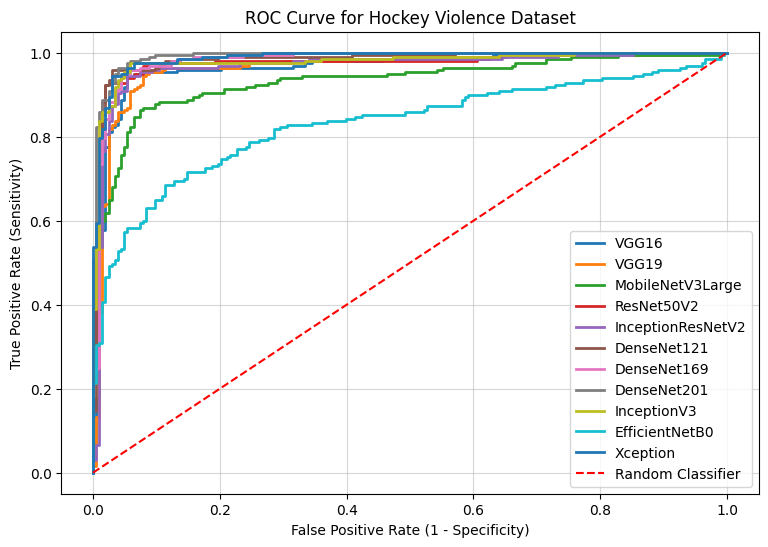

<Figure size 640x480 with 0 Axes>

In [20]:
# ✅ Plot ALL ROC curves together
plt.figure(figsize=(9,6))
for model_name, fpr, tpr in roc_data:
    plt.plot(fpr, tpr, lw=2, label=model_name)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Hockey Violence Dataset')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()
# ✅ Optional: Save the figure
plt.savefig("hockey_multi_model_roc_curve.png", dpi=300)
plt.show()